# Assignment 3


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import codecs

from scipy.stats import ttest_ind
import sys

%matplotlib inline

## Question 1 The “Business Decision”

We consider the core decision of an MBA admissions committee: *which applicants should we accept in the MBA program?* The school is interested in predicting the MBA participant’s success in the future before offering admission. 

To make this decision, the committee uses a number of data about the applicants. Let us consider for example the following attributes in evaluating an MBA application (of course in practice many more can be considered):

1. GPA
2. GMAT score
3. Scholarships, fellowships won
4. Evidence of Communications skills (debating competition, personal interview score)
5. Prior Job Experience
6. Organizational Experience
7. Other extra curricular achievements

Let us assume that this data is converted into a numerical scale from 1-7. For example: a numerical rating may be given to the fellowships based on the prestige and the number of fellowships won. Job experience may be rated on the number of years on the job, with a numerical weighting for the level of the job in the managerial ladder.

In particular, theory may suggest that there are really one or two basic factors (like intelligence and leadership skills) that lead to success in a management career. The various attributes are really different manifestations of these basic factors. But maybe there are other **hidden derived variables (factors)** in the data we have: instead of us manually combining raw attributes into meaningful derived ones, which not only is difficult with many data but also dangerous as we impose our biases, let’s get factor analysis to do the job for us - and use our intuition and judgment in the process.

In [2]:
mba_info = pd.read_csv('MBAadmin.csv')
mba_info.describe()

,GPA,GMAT,Fellow,Comm,Job.Ex,Organze,Extra
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,3.305000,583.500000,2.450000,3.335000,4.250000,3.200000,3.300000
std,0.468452,119.440582,0.905248,0.489118,1.517442,0.734847,0.515037
min,2.500000,380.000000,1.000000,2.000000,2.000000,1.000000,2.400000
25%,2.800000,480.000000,2.000000,3.175000,3.000000,3.050000,2.875000
50%,3.450000,575.000000,2.800000,3.400000,5.000000,3.400000,3.400000
75%,3.625000,682.500000,3.000000,3.725000,5.250000,3.800000,3.800000
max,3.900000,760.000000,3.800000,3.900000,6.000000,3.900000,4.000000


In [3]:
mba_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
GPA        20 non-null float64
GMAT       20 non-null int64
Fellow     20 non-null float64
Comm       20 non-null float64
Job.Ex     20 non-null int64
Organze    20 non-null float64
Extra      20 non-null float64
dtypes: float64(5), int64(2)
memory usage: 1.2 KB


### Question 1.1 (10 points)
Read the data from MBAadmin.csv and check the descriptive statistics of the data. **Implement yourself the principal component analysis** and derive 2 principal components and show how much of the variances can be explained by these 2 principal components.

In [4]:
#from sklearn.preprocessing import StandardScaler
# Standardizing the variables by removing the mean and scaling to unit variance
#mba_info = StandardScaler().fit_transform(mba_info)


In [4]:
mba_info_transform =pd.DataFrame( mba_info - mba_info.mean(axis=0),
                                 columns=["GPA","GMAT","Fellow","Comm","Job.Ex","Organze","Extra"])

In [5]:
## covarinace matrix
mba_info_cov = np.cov(mba_info_transform.T)
## Compute the eigenvalues and right eigenvectors of a square array.
eigenvalue, eigenvector = np.linalg.eig(mba_info_cov)

In [6]:
## select the first 2 principal components
PCs = eigenvector[:,:2].T

In [7]:
subspace = mba_info_transform.dot(PCs.T)

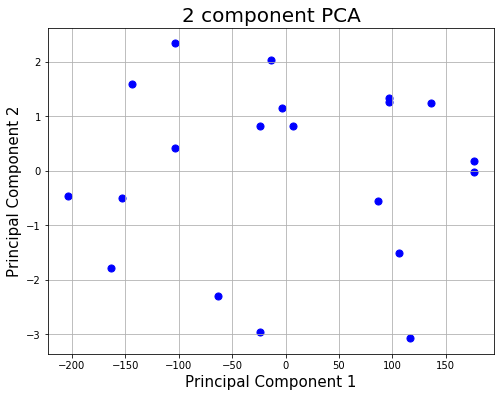

In [8]:


fig = plt.figure(figsize = (8,6))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
ax.scatter(subspace.iloc[:, 0], subspace.iloc[:, 1], c = 'b', s = 50)

ax.grid()


In [9]:
print("Explained variance : {0:1.5f}".format(np.sum(eigenvalue[:2])/np.sum(eigenvalue)))

Explained variance : 0.99996


### Question 1.2 (10 points)

Now use the sklearn.decomposition.PCA to perform principal component analysis on the data and explain which number of principal components should be chosen using Elbow method. 

In [10]:
from sklearn.decomposition import PCA
pca = PCA(n_components=len(mba_info_transform.columns))
principalComponents = pca.fit(mba_info)
PCA_Var = pd.Series( principalComponents.explained_variance_ratio_)


In [11]:
PCA_Var

0    9.997768e-01
1    1.837534e-04
2    1.713751e-05
3    1.062523e-05
4    6.447387e-06
5    4.220630e-06
6    9.948852e-07
dtype: float64

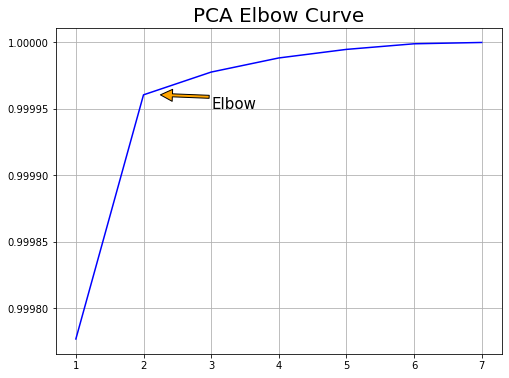

In [12]:
fig = plt.figure(figsize = (8,6))
ax = fig.add_subplot(1,1,1) 
ax.set_title('PCA Elbow Curve', fontsize = 20)
ax.plot(PCA_Var.cumsum(), c = "blue")
plt.xticks(np.arange(len(list(PCA_Var.index))), np.arange(len(list(PCA_Var.index)))+1)

ax.annotate("Elbow", xy=(1.25,  PCA_Var.cumsum()[1]),
            xytext=(2, 0.99995), arrowprops=dict(facecolor='orange', width = 3),fontsize=15)
ax.grid()
plt.show()

The cumulative sum of the explained variance from the PCA. The first and the second principal components explain already  99.996%, thus by reducing the dimension to 2, it captures most of the useful information to select the right candidates.

## Question 2 Customer Segmentation

The management team of a large shopping mall would like to understand the types of people who are, or could be, visiting their mall. They have good reasons to believe that there are a few different market segments, and they are considering designing and positioning the shopping mall services better in order to attract mainly a few profitable market segments, or to differentiate their services (e.g. invitations to events, discounts, etc) across market segments.

We aim to describe attitudes of people to shopping in a shopping mall using a small dataset. To make these decisions, the management team run a market research survey of a few potential customers. In this case this was a small survey to only a few people, where each person answered six attitudinal questions and a question regarding how often they visit the mall, all on a scale 1-7, as well as one question regarding their household income:

| Name        | Name           | Name  |
| ------------- |:-------------:| -----:|
| V1     | Shopping is fun | 1-7 |
| V2      | Shopping is bad for your budget      |  1-7 |
| V3 | I combine shopping with eating out      |    1-7 |
| V4     | I try to get the best buys while shopping | 1-7 |
| V5      | I don’t care about shopping      |  1-7 |
| V6 | You can save lot of money by comparing prices      |    1-7 |
| Income      | The household income of the respondent      |  Dollars |
| Mall.Visits | How often they visit the mall      |    1-7 |


In [13]:
mall = pd.read_csv('Mall_Visits.csv')
mall.describe()

,ID,V1,V2,V3,V4,V5,V6,Income,Mall.Visits
count,40.000000,40.000000,40.000000,40.000000,40.000000,40.0000,40.000000,40.00000,40.00000
mean,20.500000,3.850000,4.100000,3.950000,4.100000,3.4500,4.350000,46000.00000,3.25000
std,11.690452,1.874936,1.392286,1.986493,1.498717,1.7387,1.477177,17216.56924,1.94475
min,1.000000,1.000000,2.000000,1.000000,2.000000,1.0000,2.000000,25000.00000,0.00000
25%,10.750000,2.000000,3.000000,2.000000,3.000000,2.0000,3.000000,30000.00000,2.00000
50%,20.500000,4.000000,4.000000,4.000000,4.000000,3.5000,4.000000,42500.00000,3.00000
75%,30.250000,5.250000,5.000000,6.000000,5.250000,4.2500,5.250000,60000.00000,4.25000
max,40.000000,7.000000,7.000000,7.000000,7.000000,7.0000,7.000000,80000.00000,7.00000


In [14]:
mall.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 9 columns):
ID             40 non-null int64
V1             40 non-null int64
V2             40 non-null int64
V3             40 non-null int64
V4             40 non-null int64
V5             40 non-null int64
V6             40 non-null int64
Income         40 non-null int64
Mall.Visits    40 non-null int64
dtypes: int64(9)
memory usage: 2.9 KB


### Question 2.1 (10 points) 

Perform customer segmentation using k-Means algorithm by setting k=1. What can we infer from customer segmentation with one cluster? Explain this using the obtained centroid of cluster.

In [15]:
from sklearn.cluster import KMeans

In [16]:
K_fit = KMeans(n_clusters=1).fit(mall.drop("ID",axis=1)) ## k=1

In [17]:
(K_fit.cluster_centers_).astype('float64')

array([[3.85e+00, 4.10e+00, 3.95e+00, 4.10e+00, 3.45e+00, 4.35e+00,
        4.60e+04, 3.25e+00]])

Set the number of cluster to be 1, the alghoritm returns exactly the mean value. Thus the segment with the values of each feature represented at the clucster centroid.

### Question 2.2 (10 points)

Now perform customer segmentation by setting the number of k to be 3. Explain the obtained clusters. Check the distribution of each feature across the clusters and see whether these features are statisically significantly different from each other. 

In [24]:
#from sklearn.preprocessing import StandardScaler
list_name_col=list(mall.columns)[1:]
# Standardizing the variables by removing the mean and scaling to unit variance
#mall = StandardScaler().fit_transform(mall.drop("ID",axis=1))
# mall_X=pd.DataFrame(mall, columns=list_name_col)

In [25]:
K_fit_3 = KMeans(n_clusters=3).fit(mall.drop("ID",axis=1)) ## k=3

## counts of labels 
pd.Series(K_fit_3.labels_).value_counts()

0    20
1    12
2     8
dtype: int64

In [26]:
## % of counts of labels
(pd.Series(K_fit_3.labels_).value_counts()/len(K_fit_3.labels_)*100).astype("str")+"%"

0    50.0%
1    30.0%
2    20.0%
dtype: object

In [21]:
mall.describe().loc['mean']

ID                20.50
V1                 3.85
V2                 4.10
V3                 3.95
V4                 4.10
V5                 3.45
V6                 4.35
Income         46000.00
Mall.Visits        3.25
Name: mean, dtype: float64

In [22]:
float_formatter = lambda x: "%.2f" % x
np.set_printoptions(formatter={'float_kind':float_formatter})

In [23]:
res=pd.DataFrame([K_fit_3.cluster_centers_[0], K_fit_3.cluster_centers_[1],K_fit_3.cluster_centers_[2]]).T
res.columns=["Customer Segment 0","Customer Segment 1","Customer Segment 2"]
res.index=list_name_col
print(res)

             Customer Segment 0  Customer Segment 1  Customer Segment 2
V1                          2.8                4.50            5.166667
V2                          4.6                3.25            3.833333
V3                          2.6                5.50            5.166667
V4                          5.2                3.00            3.000000
V5                          4.2                3.00            2.500000
V6                          4.9                3.75            3.833333
Income                  31000.0            71250.00        54166.666667
Mall.Visits                 3.8                2.50            2.833333


0. Customer segment 0 represent 30% of all customer household income closer to the mean. They strongly belive that shopping is fun as such they most likely will do that (V1=5.17 and V5=2.5), they also avoid to check for discount opportunity (V6=3.83);


1. Customer segment 1 represent 50% of all customer base who have have the low household income. Indeed, they do not see shopping as a priority (V1=2.8 and V5=4.2, V3=2.6) and they concern get the best purchases among the main-stream brend (low cost) (V4=5.2);


2. Customer segment 2 represent 20% of all customer base who have the high-level household income. They often enjoy the shopping and probably they do not care of the impact of the total bill on their finance wealth (V2=3.25). Furthermore, they match dining outside with shopping (V3=5.5). Their vist are not that frequent in the mall, probably because they prefer high quality shops that are not located in main streams mall (V2=2.5).

In [25]:
def stat_significance():
    n=input("Enter costumer segment (between 0 and 2): ")
    m=input("Enter costumer segment (between 0 and 2): ")
    if n==m:
        print("ERROR: costumer segments are identical!")
        sys.exit()
        
    else: 
        mall["label"]=pd.Series(K_fit_3.labels_)
        columns=list(mall.drop(["ID","label"],axis=1).columns)
        
        t_test_res = {}

        for column in columns:
            segment1 = mall[mall.label==int(n)][column]
            segment2 = mall[mall.label==int(m)][column]

            t_test_res[column] = ttest_ind(segment1, segment2)

        df = pd.DataFrame.from_dict(t_test_res, orient='Index')
        df['Significant_at_5%'] = df.iloc[:,1] <= 0.05
        df.columns = ['stat','p-value', "Significance"]  
    return df

In [26]:
stat_significance()

Enter costumer segment (between 0 and 2): 0
Enter costumer segment (between 0 and 2): 2


,stat,p-value,Significance
V1,-3.082104,4.817447e-03,True
V2,2.155099,4.059163e-02,True
V3,-5.403109,1.163485e-05,True
V4,4.800794,5.685806e-05,True
V5,1.901026,6.843773e-02,False
V6,1.660048,1.089197e-01,False
Income,-17.158908,1.065245e-15,True
Mall.Visits,1.439328,1.619894e-01,False


General knowledge: A p-value less than 0.05 (typically ≤ 0.05) is statistically significant. It indicates strong evidence against the null hypothesis, as there is less than a 5% probability the null is correct (and the results are random). Therefore, we reject the null hypothesis, and accept the alternative hypothesis.
H0: The null hypothesis states that there is no relationship between the two variables being studied (one variable does not affect the other).

By looking at the p-value from the table above, all of the features are statistically significant diferent from zero except for the variable _Income_.  
(Customer segments: 0 and 2)


Note: this conclusion might be different respect the two costumers segments selected. 

### Question 2.3 (10 points)

Now perform customer segmentation by setting the number of k using the Elbow method and Silhouette score, respectively. Explain what would be the k you get from two methods.

In [27]:
#!pip install yellowbrick

In [28]:
from yellowbrick.cluster import KElbowVisualizer

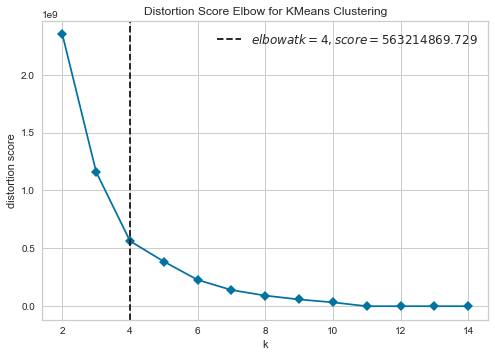

In [29]:
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,15),timings=False)

visualizer.fit(mall.drop("ID",axis=1))    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

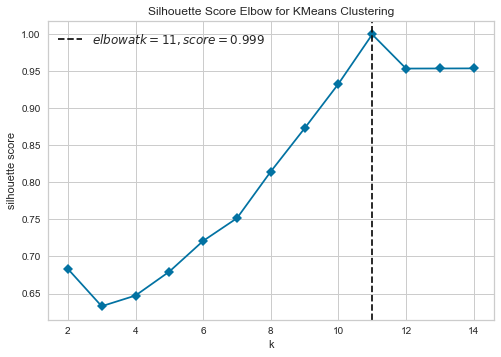

In [30]:
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(
    model, k=(2,15), metric='silhouette', timings=False
)

visualizer.fit(mall.drop("ID",axis=1))    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

The optimal number of cluster selected by "Elbow method" is either 4 or 5(automatically selected by the function).
While the one selected using the "silhouette score" is 10 which diverge substantially from the one choosed by the function (k= 5), which suggests that data is not very clustered.  Nonetheless, there are several limitations of unsupervised learning so find the optimal number of clusters is not always straighforward.

## Question 3 Birds of a feather laugh together

Jester is a research project from the UC Berkeley Laboratory for Automation Science and Engineering. Users are asked to rate the jokes they read and may see more similar jokes. The dataset `jester_dataset.zip`, when unzipped, they are in Excel (.xls) format that contains ratings from 23,500 users who have rated 36 or more jokes. Ratings are real values ranging from -10.00 to +10.00 (the value "99" corresponds to "null" = "not rated"). The text of the jokes is given `jester_dataset_joke_text.zip`. The first column gives the number of jokes rated by that user. The next 100 columns give the ratings for jokes 01 - 100.

In [31]:
import io
import zipfile
directory_to_extract_to="C:/Users/Pierfrancesco/Desktop/Machine_Learning/Assignment_3"

In [32]:

path_to_zip_file="C:/Users/Pierfrancesco/Desktop/Machine_Learning/Assignment_3/jester_dataset.zip"

with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

In [33]:
path_to_zip_file="C:/Users/Pierfrancesco/Desktop/Machine_Learning/Assignment_3/jester_dataset_joke_texts.zip"
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

In [27]:
jester = pd.read_excel('jester-data-2.xls', header=None)
jester.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23500 entries, 0 to 23499
Columns: 101 entries, 0 to 100
dtypes: float64(100), int64(1)
memory usage: 18.1 MB


In [28]:
jester.describe().T[:20]

,count,mean,std,min,25%,50%,75%,max
0,23500.0,72.723106,21.980057,36.00,53.00,72.00,100.00,100.0
1,23500.0,34.263034,46.678832,-9.95,-0.15,5.29,99.00,99.0
2,23500.0,27.652229,44.594358,-9.95,-2.28,3.79,99.00,99.0
3,23500.0,32.670040,46.724580,-9.95,-1.65,4.37,99.00,99.0
4,23500.0,35.353705,48.535436,-9.95,-3.30,3.40,99.00,99.0
5,23500.0,0.122895,5.345209,-9.95,-4.13,0.73,4.22,99.0
6,23500.0,19.161647,38.302227,-9.95,-0.92,3.01,7.82,99.0
7,23500.0,-0.479669,5.710155,-9.95,-5.58,-0.10,4.03,99.0
8,23500.0,-0.704873,5.061478,-9.95,-4.81,-0.34,3.01,99.0
9,23500.0,35.421426,48.096726,-9.95,-2.04,3.88,99.00,99.0


In [29]:
jester.rename(columns = {0:'n_jokes_rated_by_user'}, inplace=True)
jester.head()

,n_jokes_rated_by_user,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
0,50,99.00,8.11,99.00,99.0,-2.28,-4.22,5.49,-2.62,99.00,...,99.00,99.0,99.00,99.00,99.00,-5.92,99.0,99.00,99.00,99.00
1,100,-4.37,-3.88,0.73,-3.2,-6.41,1.17,7.82,-4.76,-6.41,...,5.73,-6.7,1.99,2.62,-0.49,3.45,3.2,-0.53,-0.53,-2.96
2,42,99.00,99.00,99.00,99.0,0.73,99.00,5.53,3.25,99.00,...,99.00,99.0,99.00,99.00,3.16,99.00,99.0,99.00,99.00,99.00
3,65,0.34,-6.55,2.86,99.0,-3.64,1.12,5.34,2.33,99.00,...,99.00,99.0,99.00,99.00,99.00,99.00,99.0,99.00,99.00,99.00
4,37,99.00,99.00,99.00,99.0,9.13,99.00,-9.32,-2.04,99.00,...,99.00,99.0,99.00,99.00,99.00,99.00,99.0,99.00,99.00,99.00


In [30]:
print("Check of rated jokes per user are above 36 . . .\nloading ...\n", 
      all(i >= 36 for i in jester.n_jokes_rated_by_user))

Check of rated jokes per user are above 36 . . .
loading ...
 True


In [31]:
jester.drop(["n_jokes_rated_by_user"], axis=1, inplace=True)
# jester.replace(99, np.nan, inplace=True)

In [32]:
jester.head()

,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
0,99.00,8.11,99.00,99.0,-2.28,-4.22,5.49,-2.62,99.00,-2.28,...,99.00,99.0,99.00,99.00,99.00,-5.92,99.0,99.00,99.00,99.00
1,-4.37,-3.88,0.73,-3.2,-6.41,1.17,7.82,-4.76,-6.41,0.73,...,5.73,-6.7,1.99,2.62,-0.49,3.45,3.2,-0.53,-0.53,-2.96
2,99.00,99.00,99.00,99.0,0.73,99.00,5.53,3.25,99.00,99.00,...,99.00,99.0,99.00,99.00,3.16,99.00,99.0,99.00,99.00,99.00
3,0.34,-6.55,2.86,99.0,-3.64,1.12,5.34,2.33,99.00,2.33,...,99.00,99.0,99.00,99.00,99.00,99.00,99.0,99.00,99.00,99.00
4,99.00,99.00,99.00,99.0,9.13,99.00,-9.32,-2.04,99.00,99.00,...,99.00,99.0,99.00,99.00,99.00,99.00,99.0,99.00,99.00,99.00


### Question 3.1 (10 points) 

Build a user-based collaborative filtering and provide a list of top 5 jokes for the first user. Check the text of jokes to see if the recommendations are sensible. 

In [33]:
from sklearn.metrics.pairwise import cosine_similarity

In [34]:
cosine = cosine_similarity(jester)
#np.fill_diagonal(cosine, 0 )
similarity_joke_matrix = pd.DataFrame(cosine , index = jester.index)
similarity_joke_matrix.columns = jester.index


In [35]:
def user_base_collaborative_filter(user_id=0):
    top_n_user=int(input("Enter the top N users for similarity: ... "))
    ## create a list of unseen joke for the user_id
    unseen_joke_idx= jester.columns[jester.iloc[user_id,:]==99].tolist()
    ## select from the cosine similarity matrix the correspondent values sorted and select the TOP N Users more similar
    similar_user_target=similarity_joke_matrix.iloc[1:,user_id].sort_values(ascending=False)[:top_n_user]
    ## from the rating matrix sort by unseen jokes and cosini similarity indexes 
    unseen_joke_allrating=jester.loc[similar_user_target.index,unseen_joke_idx]
    res = pd.DataFrame(unseen_joke_idx, columns=["Unseen Joke"])
    
    ratings=[]
    for  name in list(unseen_joke_allrating.columns):
        ## collect the rating of each jokes differents from 99
            rating_calc= unseen_joke_allrating.loc[(unseen_joke_allrating.loc[:,name] < 99),name]
            # check whethere does not exist any rating given by all users selected 
            if all(rating_calc==0):
                ratings.append(0)
            else:
                ## select the correspondent Similarity weights
                w=similar_user_target.loc[rating_calc.index]
                ## compute the weighted average
                ratings.append(np.average(rating_calc, weights=w))
    
    res["rating_forecast"]=ratings
    
    global top5_reccommendation
    ## take only the top 5 reccommendation
    top5_reccommendation= res.sort_values(by="rating_forecast",axis=0,ascending=False)[:5]
    return print(top5_reccommendation.to_string(index=False))

In [36]:
user_base_collaborative_filter(0)
                              

Enter the top N users for similarity: ... 1000
 Unseen Joke  rating_forecast
          72         3.349763
           1         2.871186
          78         2.748921
          33         2.732279
          76         2.666660


In [37]:
for joke in list(top5_reccommendation['Unseen Joke']):
    ## read the HTML files (joke texts)
    joke_str = 'jokes/init' + str(joke) + '.html'
    f = codecs.open(joke_str, 'r')
    s = f.read()
    ## find the end and the beginning of the joke 
    beg = s.find('<!--begin of joke -->') + len('<!--begin of joke -->')
    end = s.find('<!--end of joke -->')
    print('Joke {}'.format(joke))
    print(s[beg:end])
    print('~~~~~~~~~~~~~~~~~~~~~~~~')

Joke 72

On the first day of college, the Dean addressed the students,
pointing out some of the rules:

"The female dormitory will be out-of-bounds for all male students
and the male dormitory to the female students. Anybody caught breaking
this rule will be finded $20 the first time." He continued, "Anybody 
caught breaking this rule the second time will be fined $60. Being caught
a third time will cost you a fine of $180. Are there any questions ?"
<p>
At this point, a male student in the crowd inquired:
<i>"How much for a season pass ?"</i>

~~~~~~~~~~~~~~~~~~~~~~~~
Joke 1

A man visits the doctor. The doctor says "I have bad news for you.You have
cancer and Alzheimer's disease". <P>
The man replies "Well,thank God I don't have cancer!"

~~~~~~~~~~~~~~~~~~~~~~~~
Joke 78

Q: What's the difference between the government  and  the Mafia?
<p>
A: <i>One of them is organized</i>.

~~~~~~~~~~~~~~~~~~~~~~~~
Joke 33

What do you call an American in the finals of the world cup?
<P>
"Hey Beer 

The jokes selected seems to describe a creepy/cruel situation talking about death, illness and other unethical manner. So probably the model made a good selection of jokes for the user 0. 

### Question 3.2 (10 points) 

Build a item-based collaborative filtering and provide a list of top 5 jokes for the first user. Check the text of jokes to see if the recommendations are sensible.

In [38]:
cosine = cosine_similarity(jester.T) ## cosine similiarity per jokes
#np.fill_diagonal(cosine, 0 )
similarity_joke_matrix = pd.DataFrame(cosine , index = jester.columns)
similarity_joke_matrix.columns = jester.columns


In [39]:
def item_base_collaborative_filter(user_id=0):
    global res
    res = pd.DataFrame(jester.columns, columns=["Joke_ID"])

    forecast_rating=[]

    for joke_id in jester.columns:
        ## select for every joke the most similar by looking at the top 10 cosine similarity
        top_n_similarity_per_joke=similarity_joke_matrix.loc[:,joke_id].sort_values(ascending=False)[1:11]

        indx_joke=top_n_similarity_per_joke.index.to_list()
        ## create a dataframe that contain the similiraty of jokes and the corresponding rating given by user_id=0
        df=pd.DataFrame(similarity_joke_matrix.loc[joke_id, indx_joke].values,index=similarity_joke_matrix.loc[joke_id, indx_joke].index
                        , columns=["similarity"])
        df['rating']=jester.loc[user_id,indx_joke]
        ## get rid off the non rated jokes 
        df=df[df.rating<99]    

        try:
            forecast_rating.append(np.average(df.rating, weights=df.similarity))
    ## if error continue the loop (the error is that the df does not contain any info)
        except:
            forecast_rating.append(None)
            continue

    res['rating_forecast']=forecast_rating

In [40]:
item_base_collaborative_filter(user_id=0)

In [41]:
unseen_joke_idx= (jester.iloc[0,:]==99).tolist()
res['user_unseen']=unseen_joke_idx
top_5=res[res.user_unseen==True].sort_values(by=['rating_forecast'],axis=0, ascending=False)[:5]
print(top_5.iloc[:,0:2].to_string(index=False))

Joke_ID  rating_forecast
      3             8.11
     84             1.21
     82             1.21
     91             1.21
     90             1.21


In [42]:
for joke in list(top_5['Joke_ID']):
    ## read the HTML files (joke texts)
    joke_str = 'jokes/init' + str(joke) + '.html'
    f = codecs.open(joke_str, 'r')
    s = f.read()
    ## find the end and the beginning of the joke 
    beg = s.find('<!--begin of joke -->') + len('<!--begin of joke -->')
    end = s.find('<!--end of joke -->')
    print('Joke {}'.format(joke))
    print(s[beg:end])
    print('~~~~~~~~~~~~~~~~~~~~~~~~')

Joke 3

Q. What's 200 feet long and has 4 teeth? <P>

A. The front row at a Willie Nelson Concert.

~~~~~~~~~~~~~~~~~~~~~~~~
Joke 84

Q: What is the difference between Mechanical Engineers and Civil 
Engineers?
<p> 
A: Mechanical Engineers build <i>weapons</i>, Civil Engineers build <i>targets</i>.

~~~~~~~~~~~~~~~~~~~~~~~~
Joke 82

Q: How do you keep a computer programmer in the 
shower all day long?
<p>
A: Give them a shampoo with a label that says
<i>"rinse, lather, repeat"</i>.

~~~~~~~~~~~~~~~~~~~~~~~~
Joke 91

A Panda bear walks into a bar.  Sits down at a table and orders a beer 
and a double cheeseburger.  After he is finished eating, he pulls out a gun
and rips the place with gunfire.  Patrons scatter and dive under chairs and
tables as the bear runs out the door.  After ensuring that no one is hurt, 
the bartender races out the door, and calls after the bear "What the hell did
you do that for?"  The bear calls back, "I'm a Panda bear.  Look it up in the
dictionary."  
<p>
The

The jokes reccommended are around the topic of computer science/programming. Therefore the model is selecting a good reccommendation of jokes. 

### Question 3.3 (20 points) 

Now build a recommendation system using matrix factorization (singular value decomposition). Get a list of top 5 jokes for the first user. Explain whether model-based recoomendation approach is better than neighborhood-based approach. Write a function that takes the parameter of user_id and return the text of recommended jokes)

In [43]:
from scipy.sparse.linalg import svds

In [44]:
jester = jester.replace(99, 0)
U, sigma, Vt = svds(jester.values)
sigma = np.diag(sigma)
predicted_ratings = np.dot(np.dot(U, sigma), Vt)

# select jokes with highest predicting rating but not yet rated
def svds_recommendation(user_id=0):
    #user_id=int(input("Do you wanna change user ID? (default 0):   "))
    ## create a list of highest predicted rating unseen by the user
    recommended_jokes = []

    for indx in np.argsort(predicted_ratings[user_id])[::-1]:
        if jester.iloc[0,indx] == 0:
            recommended_jokes.append(indx)
    global res
    res = recommended_jokes[:5]      
    return print('The recommendation system using matrix factorization returns:\nloading ...\njokes: {}'.format(res))

In [46]:
predicted_ratings[0]

array([-0.31, -0.60, -0.67, -1.19, -0.87, 0.52, -1.38, -1.43, -0.82,
       -0.10, 0.48, 0.84, -2.08, 0.58, -2.40, -2.59, -1.36, -1.07, -0.17,
       -1.09, 1.04, -0.05, -0.30, -1.38, -0.25, 0.59, 1.65, 0.91, 1.29,
       -0.68, 1.08, 1.86, -1.21, 0.33, 1.64, 1.51, -1.21, 0.46, 0.44,
       0.10, -0.98, 0.97, -0.92, -1.53, 0.23, 0.48, 0.98, 1.05, 1.66,
       1.87, -1.07, -0.65, 1.59, 1.54, -0.24, 1.02, -1.44, -1.97, -0.65,
       -0.91, 1.21, 1.87, 0.09, -1.06, 1.16, 1.59, -1.01, 1.80, 1.46,
       0.19, -0.42, 0.28, -0.15, -0.69, -0.43, 0.19, -0.14, -0.01, -0.35,
       -0.12, -0.01, -0.22, 0.13, -0.20, -0.38, -0.35, 0.08, 0.11, 0.53,
       -0.25, 0.12, 0.00, 0.25, -0.14, -0.12, 0.02, 0.07, -0.09, -0.31,
       -0.28])

In [76]:
svds_recommendation()

The recommendation system using matrix factorization returns:
loading ...
jokes: [38, 33, 71, 92, 75]


The  recommendation system using matrix factorization is in the most of the cases quicker than neighborhood-based approach, especially when dealing with large datasets. 

In [77]:
def print_jokes(user_id=0):
    user_id=int(input("Do you wanna change user ID? (default 0):   "))
    svds_recommendation(user_id=user_id)
    for joke in res:
        ## read the HTML files (joke texts)
        joke_str = 'jokes/init' + str(joke) + '.html'
        f = codecs.open(joke_str, 'r')
        s = f.read()
        ## find the end and the beginning of the joke 
        beg = s.find('<!--begin of joke -->') + len('<!--begin of joke -->')
        end = s.find('<!--end of joke -->')
        print('Joke {}'.format(joke))
        print(s[beg:end])
        print('~~~~~~~~~~~~~~~~~~~~~~~~')

In [78]:
print_jokes()

Do you wanna change user ID? (default 0):   214
The recommendation system using matrix factorization returns:
loading ...
jokes: [38, 33, 51, 50, 69]
Joke 38

"May I take your order?" the waiter asked. 
<P>
"Yes, how do you prepare your chickens?" 
<P>
"Nothing special sir," he replied. "We just tell them straight out
that they're going to die."

~~~~~~~~~~~~~~~~~~~~~~~~
Joke 33

What do you call an American in the finals of the world cup?
<P>
"Hey Beer Man!"

~~~~~~~~~~~~~~~~~~~~~~~~
Joke 51

Did you hear that Clinton has announced there is a new national bird?  
<p>The spread eagle.

~~~~~~~~~~~~~~~~~~~~~~~~
Joke 50

A guy goes into confession and says to the priest, "Father, I'm 80 years
old, widower, with 11 grandchildren. Last night I met two beautiful flight
attendants. They took me home and I made love to both of them. Twice."
<P>
The priest said: "Well, my son, when was the last time you were in
confession?"
<p> "Never Father, I'm Jewish."
<p> "So then, why are you telling me?"